In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import matrix_power

In [2]:
df = pd.read_excel('/content/Final_Dataset.xlsx',parse_dates=['Date'], index_col='Date')
df = df[['Gold_price(USD/Ounce)']]

# Calculate percentage change
df['Returns'] = df['Gold_price(USD/Ounce)'].pct_change()

In [3]:
df.head(2)

,Gold_price(USD/Ounce),Returns
Date,,
2010-12-31,1421.100,NaN
2011-01-31,1333.801,-0.061431


In [4]:
df.dropna(inplace=True)

In [5]:
# Assigning states
def assign_state(change):
    if pd.isna(change):
        return np.nan
    if change < -0.01:
        return 'down'
    elif change > 0.01:
        return 'up'
    else:
        return 'stable'

df['State'] = df['Returns'].apply(assign_state)
df = df.dropna(subset=['State'])

In [6]:
# transition matrix for the real data
states = ['down', 'stable', 'up']
matrix = pd.DataFrame(0, index=states, columns=states)

for i in range(len(df) - 1):
    current = df['State'].iloc[i]
    next_ = df['State'].iloc[i + 1]
    matrix.loc[current, next_] += 1

transition_matrix_real = matrix.div(matrix.sum(axis=1), axis=0).fillna(1/3)

In [7]:
transition_matrix_real

,down,stable,up
down,0.322581,0.290323,0.387097
stable,0.428571,0.171429,0.400000
up,0.385714,0.157143,0.457143


In [8]:
df.head()

,Gold_price(USD/Ounce),Returns,State
Date,,,
2011-01-31,1333.801,-0.061431,down
2011-02-28,1409.301,0.056605,up
2011-03-31,1438.901,0.021003,up
2011-04-30,1556.000,0.081381,up
2011-05-31,1533.350,-0.014557,down


In [9]:
  # Simulate future state
n_steps = 3
n_simulations = 10000
last_state = df['State'].iloc[-1]
simulations = []

In [10]:
# simulating the next states
for _ in range(n_simulations):
    state = last_state
    for _ in range(n_steps):
        state = np.random.choice(states, p=transition_matrix_real.loc[state])
    simulations.append(state)

In [11]:
# Converting list into Dataframe
simulations_df = pd.DataFrame(simulations)

In [12]:
matrix1 = pd.DataFrame(0, index=states, columns=states)

for i in range(len(simulations_df) - 1):
    current = simulations_df[0].iloc[i]
    next_ = simulations_df[0].iloc[i + 1]
    matrix1.loc[current, next_] += 1

transition_matrix_simulation = matrix1.div(matrix1.sum(axis=1), axis=0).fillna(1/3)

In [13]:
transition_matrix_simulation

,down,stable,up
down,0.380990,0.203336,0.415674
stable,0.383390,0.208595,0.408015
up,0.371959,0.209829,0.418212


# Checking for Steady State

In [14]:
# Reaching the Steady State for the real data
for i in range(1, 4):  # 2^1 to 2^3
    power = 2 ** i
    P_power = matrix_power(transition_matrix_real, power)
    print(f"\nP^{power}:\n", np.round(P_power, 4))


P^2:
 [[0.3778 0.2043 0.418 ]
 [0.366  0.2167 0.4173]
 [0.3681 0.2108 0.4211]]

P^4:
 [[0.3713 0.2095 0.4192]
 [0.3712 0.2097 0.4192]
 [0.3712 0.2096 0.4192]]

P^8:
 [[0.3713 0.2096 0.4192]
 [0.3713 0.2096 0.4192]
 [0.3713 0.2096 0.4192]]


In [15]:
# Reaching the Steady State for the simulated data
for i in range(1, 4):  # 2^1 to 2^3
    power = 2 ** i
    P_power = matrix_power(transition_matrix_simulation, power)
    print(f"\nP^{power}:\n", np.round(P_power, 4))


P^2:
 [[0.3777 0.2071 0.4152]
 [0.3778 0.2071 0.4151]
 [0.3777 0.2072 0.4151]]

P^4:
 [[0.3777 0.2071 0.4151]
 [0.3777 0.2071 0.4151]
 [0.3777 0.2071 0.4151]]

P^8:
 [[0.3777 0.2071 0.4151]
 [0.3777 0.2071 0.4151]
 [0.3777 0.2071 0.4151]]


# Predicting Future Prices


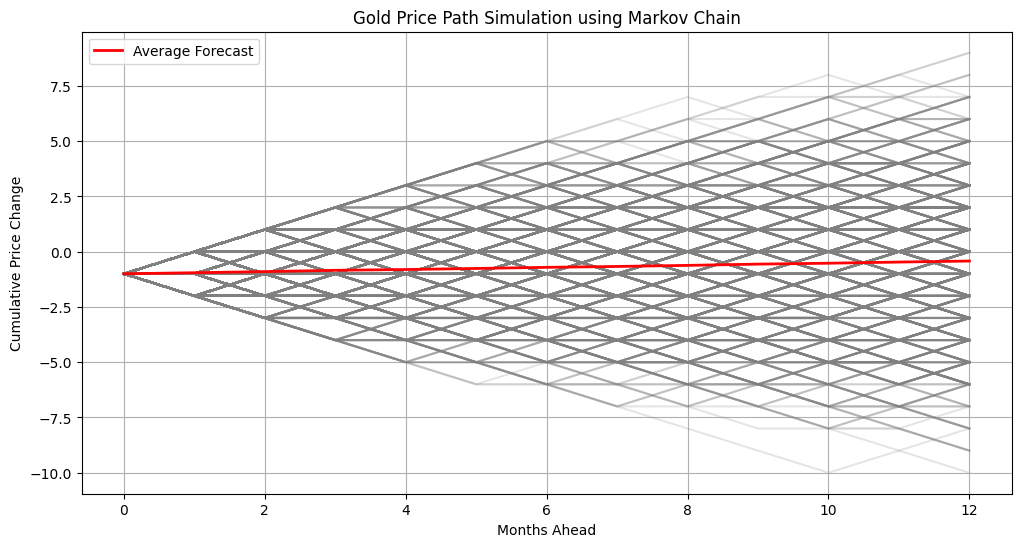

In [21]:
state_to_change = {
    'down': -1,
    'stable': 0,
    'up': 1
}

# Simulation function using named states
def simulate_path(P, state_to_change, start_state, steps):
    path = [start_state]
    for _ in range(steps):
        current_state = path[-1]
        next_state = np.random.choice(P.columns, p=P.loc[current_state].values)
        path.append(next_state)
    # Convert states to price movements
    price_changes = [state_to_change[state] for state in path]
    return np.cumsum(price_changes)

n_simulations = 10000
n_steps = 12
start_state = df['State'].iloc[-1]

# Simulate multiple paths
all_paths = np.array([
    simulate_path(transition_matrix_real, state_to_change, start_state, n_steps)
    for _ in range(n_simulations)
])

# Compute average forecast
average_forecast = np.mean(all_paths, axis=0)

# Plot results
plt.figure(figsize=(12, 6))
for i in range(1000):
    plt.plot(all_paths[i], color='gray', alpha=0.2)
plt.plot(average_forecast, color='red', linewidth=2, label='Average Forecast')
plt.title("Gold Price Path Simulation using Markov Chain")
plt.xlabel("Months Ahead")
plt.ylabel("Cumulative Price Change")
plt.legend()
plt.grid(True)
plt.show()
